In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
import re
import string

from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
set(stopwords.words('english'))

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [3]:
files=['../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv',
       '../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv',
       '../input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv',
       '../input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv'
      ]

def load_data(file):
    return pd.read_csv(file)
with multiprocessing.Pool() as pool:
    test,train,all_data,sub=pool.map(load_data,files)

In [4]:
# for col in all_data.columns:
#     print("{} -----------> {}".format(col,all_data[col].dtypes))
#     print("{} ===========> {}".format(col,train[col].dtypes))
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [5]:
train.target.value_counts(dropna=True).head()

0.000000    1264764
0.166667     138501
0.200000     107492
0.300000      59098
0.400000      50013
Name: target, dtype: int64

In [6]:
train.shape

(1804874, 45)

In [7]:
train['target'].isnull().sum()

0

In [8]:
X=train[['comment_text','target']]
train.columns.values

array(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist',
       'bisexual', 'black', 'buddhist', 'christian', 'female',
       'heterosexual', 'hindu', 'homosexual_gay_or_lesbian',
       'intellectual_or_learning_disability', 'jewish', 'latino', 'male',
       'muslim', 'other_disability', 'other_gender',
       'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white',
       'created_date', 'publication_id', 'parent_id', 'article_id',
       'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'sexual_explicit', 'identity_annotator_count',
       'toxicity_annotator_count'], dtype=object)

In [9]:
del train

In [10]:
tox=0
neut=0
no_of_rows=X.shape[0]
for row in range(no_of_rows):
    if X['target'][row]>0.7:
        tox+=1
    else:
        neut+=1

In [11]:
print(f'{round((tox*100)/no_of_rows,3)}% data contains toxic comments')
print(f'{round((neut*100/no_of_rows),3)}% data contains neutral comments')

2.518% data contains toxic comments
97.482% data contains neutral comments


# **Preprocessing comment_text for training**

In [12]:
# remove all numbers with letters attached to them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# '[%s]' % re.escape(string.punctuation),' ' - replace punctuation with white space
# .lower() - convert all strings to lowercase 
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

# Remove all '\n' in the string and replace it with a space
remove_n = lambda x: re.sub("\n", " ", x)

# Remove all non-ascii characters 
remove_non_ascii = lambda x: re.sub(r'[^\x00-\x7f]',r' ', x)

# Apply all the lambda functions wrote previously through .map on the comments column
X['comment_text'] = X['comment_text'].map(alphanumeric).map(punc_lower).map(remove_n).map(remove_non_ascii)

In [13]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def wordcloud(df, label):
    
    
    subset=df[df[label]>0.7]
    text=subset.comment_text.values
    wc= WordCloud(background_color="white",max_words=4000)

    wc.generate(" ".join(text))

    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

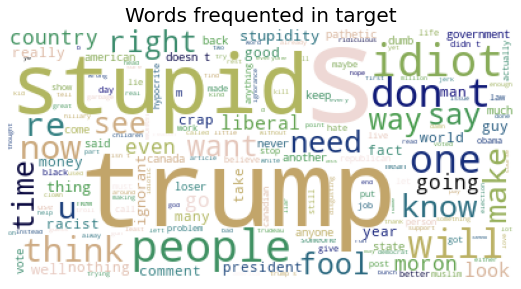

In [14]:
wordcloud(X,'target')

# Handling Class Imbalance

In [15]:
toxic_train=X[X['target']>0.7].iloc[0:45451,:]
toxic_train.shape

(45451, 2)

In [16]:
neutral_train=X[X['target']<=0.7].iloc[0:150000,:]
neutral_train.shape

(150000, 2)

In [17]:
balanced_train=pd.concat([toxic_train,neutral_train],axis=0)
balanced_train.shape

# balanced_train=X

(195451, 2)

In [18]:
del toxic_train, neutral_train

In [19]:
# Import packages for pre-processing
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel

# Import tools to split data and evaluate model performance
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

# Import ML algos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model F1 Score Comparison 

In [20]:
'''
vectorizer values: CountVectorizer, TfidfVectorizer
gram_range values: (1,1) for unigram, (2,2) for bigram
'''
def cv_tf_train_test(df_done,label,vectorizer,ngram):

    ''' Train/Test split'''
    # Split the data into X and y data sets
    X = df_done.comment_text
    y = df_done[label]

    # Split our data into training and test data 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    ''' Count Vectorizer/TF-IDF '''

    # Create a Vectorizer object and remove stopwords from the table
    cv1 = vectorizer(ngram_range=(ngram), stop_words='english')
    
    X_train_cv1 = cv1.fit_transform(X_train) # Learn the vocabulary dictionary and return term-document matrix
    X_test_cv1  = cv1.transform(X_test)      # Learn a vocabulary dictionary of all tokens in the raw documents.
    
        
    ''' Initialize all model objects and fit the models on the training data '''
    lr = LogisticRegression()
    lr.fit(X_train_cv1, y_train)
    print('lr done')

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_cv1, y_train)


    xgb=XGBClassifier()
    xgb.fit(X_train_cv1,y_train)
    
    svm_model = LinearSVC()
    svm_model.fit(X_train_cv1, y_train)

    randomforest = RandomForestClassifier(n_estimators=100, random_state=42)
    randomforest.fit(X_train_cv1, y_train)
    print('rdf done')
    
    # Create a list of F1 score of all models 
    f1_score_data = {'F1 Score':[f1_score(lr.predict(X_test_cv1), y_test), f1_score(knn.predict(X_test_cv1), y_test), 
                                f1_score(xgb.predict(X_test_cv1),y_test),
                                f1_score(svm_model.predict(X_test_cv1), y_test), f1_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels 
    df_f1 = pd.DataFrame(f1_score_data, index=['Log Regression','KNN', 'XGB', 'SVM', 'Random Forest'])

#     accuracy_data = {'Accuracy Score':[accuracy_score(lr.predict(X_test_cv1), y_test), accuracy_score(knn.predict(X_test_cv1), y_test), 
#                                 accuracy_score(xgb.predict(X_test_cv1),y_test),
#                                 accuracy_score(svm_model.predict(X_test_cv1), y_test), accuracy_score(randomforest.predict(X_test_cv1), y_test)]} 
                          
    # Create DataFrame with the model names as column labels 
#     df_acc = pd.DataFrame(accuracy_data, index=['Log Regression','KNN', 'XGB', 'SVM', 'Random Forest'])
    return df_f1


# Assigning Binary Value to Labels

In [21]:
balanced_train['target']=np.where(balanced_train['target']>0.7,1.0,0.0)
balanced_train.head()

,comment_text,target
4,haha you guys are a bunch of losers,1.0
31,yet call out all muslims for the acts of a few...,1.0
34,this bitch is nuts who would read a book by a...,1.0
289,you re an idiot,1.0
306,who cares stark trek and star wars fans are ...,1.0


In [22]:
import time

t0 = time.time()

df_tox_cv = cv_tf_train_test(balanced_train, 'target', TfidfVectorizer, (1,1))
df_tox_cv.rename(columns={'F1 Score': 'F1 Score(target)'}, inplace=True)

t1 = time.time()

total = 'Time taken: {} seconds'.format(t1-t0)
print(total)

df_tox_cv

lr done
[13:13:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
rdf done
Time taken: 1087.187702178955 seconds


,F1 Score(target)
Log Regression,0.827090
KNN,0.189752
XGB,0.801056
SVM,0.849977
Random Forest,0.819090


In [23]:
X = balanced_train.comment_text
y = balanced_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
tfv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

X_train_fit = tfv.fit_transform(X_train)  # Convert the X data into a document term matrix dataframe
X_test_fit = tfv.transform(X_test)  # Converts the X_test comments into Vectorized format


# SVM CLassifier

In [24]:
# from sklearn.calibration import CalibratedClassifierCV
# svm_model = LinearSVC()
# clf = CalibratedClassifierCV(svm_model) 
# clf.fit(X_train_fit, y_train)
    

# my_ans=[]
# for row in range(test.shape[0]):
#     comment=[test['comment_text'][row]]
#     cmt=tfv.transform(comment)
#     my_ans.append(clf.predict_proba(cmt)[:,1])

# data={'id':[],
#       'prediction':[]
#      }
# df=pd.DataFrame(data)

# df['id']=test['id']

# df['prediction']=pd.DataFrame(my_ans)

# Logistic Regressor CLassifier

In [25]:
# lr=LogisticRegression()
# lr.fit(X_train_fit,y_train)

# my_ans=[]
# for row in range(test.shape[0]):
#     comment=[test['comment_text'][row]]
#     cmt=tfv.transform(comment)
#     my_ans.append(lr.predict_proba(cmt)[:,1])

# data={'id':[],
#       'prediction':[]
#      }
# df=pd.DataFrame(data)

# df['id']=test['id']

# df['prediction']=pd.DataFrame(my_ans)

# Random Forest CLassifier

In [26]:
randomforest = RandomForestClassifier(n_estimators=100,random_state=42)
randomforest.fit(X_train_fit,y_train)

my_ans=[]
for row in range(test.shape[0]):
    comment=[test['comment_text'][row]]
    cmt=tfv.transform(comment)
    my_ans.append(randomforest.predict_proba(cmt)[:,1])

data={'id':[],
      'prediction':[]
     }
df=pd.DataFrame(data)

df['id']=test['id']

df['prediction']=pd.DataFrame(my_ans)

In [27]:
df.to_csv('submission.csv',index=False)